In [1]:
import os
import numpy as np
from uncertainty_motion_prediction.dataloader import Dataloader

dataset=Dataloader();
traj_dataset = dataset.load(0)

# Get trajectories from the dataset

## As a list of Pandas dataframes

In [2]:
trajlets = traj_dataset.get_trajlets(length=4.8)
len(trajlets)

768

In [3]:
trajlets[0]

,frame_id,agent_id,pos_x,pos_y,vel_x,vel_y,scene_id,label,timestamp
5,804,2,13.017548,5.782591,-2.324444,-0.076606,0,pedestrian,53.6
7,810,2,12.087770,5.751949,-1.589052,-0.065971,0,pedestrian,54.0
9,816,2,11.746306,5.729815,-1.140766,0.105373,0,pedestrian,54.4
10,822,2,11.175158,5.836247,-1.640021,0.179235,0,pedestrian,54.8
11,828,2,10.434290,5.873203,-1.406129,0.419050,0,pedestrian,55.2
13,834,2,10.050254,6.171487,-1.078742,0.455190,0,pedestrian,55.6
15,840,2,9.571296,6.237355,-1.207725,0.115437,0,pedestrian,56.0
19,846,2,9.084074,6.263836,-1.273181,0.170841,0,pedestrian,56.4
24,852,2,8.552751,6.374027,-1.232733,0.271502,0,pedestrian,56.8
29,858,2,8.097887,6.481037,-1.146730,0.217892,0,pedestrian,57.2


## As numpy array

In [4]:
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Kalman filter predictor using Constant Velocity model

Instantiate the Kalman filter using the Constant Velocity model, and perform some sanity checks.

In [5]:
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import ConstantVelocityKFPredictor

In [6]:
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4)
test_traj1 = [[1, 1, 1, 0],
              [1.4, 1, 1, 0],
              [1.8, 1, 1, 0]]
test_traj2 = [[1.1, 1, 0, 1],
              [0.9, 1.4, 0, 1],
              [1.2, 1.8, 0, 1]] # inject some noise into the x-position
predicted_traj = pred.predict_batch(np.array([test_traj1, test_traj2]))
print(predicted_traj[:, :, 0:2])

[[[2.2        1.        ]
  [2.6        1.        ]
  [3.         1.        ]
  [3.4        1.        ]]

 [[1.11711027 2.2       ]
  [1.11977186 2.6       ]
  [1.12243346 3.        ]
  [1.12509506 3.4       ]]]


# Evaluate ADE and FDE

Constant velocity predictor requires no training, hence there is no need to split the trajectories into train and validation sets.

In [7]:
Q = np.eye(4) * 0.05
R = np.eye(4) * 0.05
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4, Q=Q, R=R)
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(pred, trajlets)

{'fde': array([0.09121543, 0.35613147, 0.64798957, 0.68367707, 0.07478955,
        0.53448364, 0.44700206, 0.08937781, 0.12269135, 0.12690077,
        0.08721098, 0.05512167, 0.21974998, 0.11058267, 0.13303096,
        0.09954359, 0.49517369, 0.22910926, 0.41592374, 0.17080224,
        0.04483227, 0.17200489, 0.05968449, 0.02567403, 0.09403724,
        0.12383469, 0.08875242, 0.31252419, 0.16642259, 0.24441784,
        0.11347444, 0.15309609, 0.09496477, 0.16384359, 0.01946028,
        0.24209611, 0.66298158, 0.1610866 , 0.26537228, 0.10580755,
        0.09592448, 0.15099073, 0.15237816, 0.3599677 , 0.23621986,
        0.05507596, 0.19862772, 0.35946624, 0.07084167, 0.23902637,
        0.19019836, 0.19511988, 0.01051989, 0.54989129, 0.10461155,
        0.26954571, 0.122618  , 0.43294332, 0.02583176, 0.07236829,
        0.67264117, 0.19822403, 0.2924017 , 0.39215911, 0.20009366,
        0.01696236, 0.43844865, 0.23218429, 0.06652192, 0.14375715,
        0.36026315, 0.27224937, 0.0903124

# Visualize distribution of future trajectories

In [8]:
from uncertainty_motion_prediction.visualizer import SamplingVisualizer

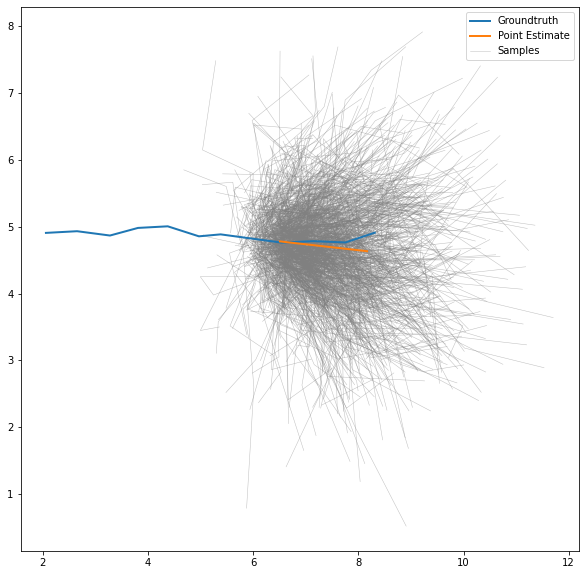

In [9]:
import matplotlib.pyplot as plt

Q = np.eye(4) * 0.05
R = np.eye(4) * 0.05
pred = ConstantVelocityKFPredictor(N_future=4, dt=0.4, Q=Q, R=R)
viz = SamplingVisualizer(N_future=4, sample_size=1000)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

traj = trajlets[155, :, :]
viz.visualize_to_axis(axs, pred, traj)

In [10]:
samples = pred.sample(traj, count=1000)
print(pred.predict(traj))

[[ 8.88011512  4.93094218]
 [ 9.44356785  4.98500107]
 [10.00702058  5.03905996]
 [10.57047331  5.09311885]]


In [11]:
print(np.cov(samples.reshape(1000, 8).T))

[[ 9.59120791e-02 -3.82881043e-04  1.01788395e-01 -4.15824610e-03
   1.04119047e-01 -9.32386921e-03  1.24292498e-01 -2.33901129e-02]
 [-3.82881043e-04  8.94886852e-02 -4.68833491e-03  9.84123373e-02
  -8.40546520e-03  1.05234937e-01 -1.22178544e-02  1.06419579e-01]
 [ 1.01788395e-01 -4.68833491e-03  2.62789441e-01  4.91345029e-04
   3.03750003e-01  7.81189509e-03  3.51504202e-01 -6.11616530e-03]
 [-4.15824610e-03  9.84123373e-02  4.91345029e-04  2.78222556e-01
   4.69378061e-03  3.20597719e-01  4.50122157e-03  3.45792691e-01]
 [ 1.04119047e-01 -8.40546520e-03  3.03750003e-01  4.69378061e-03
   6.50625052e-01  2.49160722e-02  7.69563053e-01  1.09827991e-02]
 [-9.32386921e-03  1.05234937e-01  7.81189509e-03  3.20597719e-01
   2.49160722e-02  6.51936293e-01  5.32943891e-02  7.15452131e-01]
 [ 1.24292498e-01 -1.22178544e-02  3.51504202e-01  4.50122157e-03
   7.69563053e-01  5.32943891e-02  1.33000617e+00  2.26839000e-02]
 [-2.33901129e-02  1.06419579e-01 -6.11616530e-03  3.45792691e-01
   

In [12]:
np.mean(samples, axis=0)

array([[ 8.88205607,  4.92836906],
       [ 9.43847882,  4.98991135],
       [ 9.98725826,  5.03427424],
       [10.55303632,  5.1107781 ]])